# Warsztaty modelowania w nanofizyce
----
## Wizualizacja struktur atomowych

**Paweł T. Jochym**

Zakład komputerowych badań materiałów

Instytut Fizyki Jądrowej PAN, Kraków

---
Wszelkiego rodzaju wizualizacje sa niezwykle ważnym elaementem pracy badawczej. 
* Pozwalają na efektywną kontrolę poprawności obliczeń
* Ułatwiaja dostrzeżenie pojawiających się trendów/zjawisk
* Pozwalają na wydobycie trudnych do zauważenia zależności w wynikach
* Ułatwiają i czynią przystępnym przekaz zawarty w ostatecznej publikacji

Niestety także:
* Są czaso- i praco-chłonne 
* Wymagają umiejętnego wykonania aby zachować estetykę, czytelność
* Bywają mylące - niepostrzeżenie wzmacniając efekty o małej wadze 

Poniższe ćwiczenia prezentują proste techniki tworzenia struktur atomowych (klastrów, kryształów, powierzchni) oraz wizualizacji uzyskanych układów. Istnieją liczne narzędzia służące do tego celu. Wiele z nich pozwala tworzyć wyrafinowane i piękne wizualizacje. Tutaj przedstawione są jedynie techniki możliwe do zastosowania w środowisku Jupyter na obecnym etapie jego rozwoju.

### Tworzenie struktury

Zdefiniowanie struktury wymaga podania jej składu atomowego oraz pozycji jej składników. W przypadku struktur krystalicznych powinniśmy także określić ich symeterię oraz rozmiar i rodzaj ich komórki elementarnej.

Zacznijmy od jednej z najprostszych struktur krystalicznych. 

#### Diament

In [68]:
# Import potrzebnych modułów
from ase.build import bulk
from ase.build import graphene_nanoribbon
from ase.build import nanotube
from ase.build import surface
from ase.lattice.spacegroup import crystal
import ase.io
from IPython.core.display import Image
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from io import BytesIO

In [33]:
diament=bulk(name='C',crystalstructure='diamond',a=4,cubic=True)

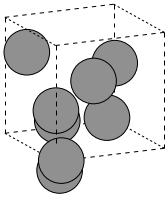

In [49]:
# Zapis obrazu kryształu na dysk
ase.io.write('diament.png',       # Nazwa pliku
             diament,             # obiekt zawierający definicję struktury
             show_unit_cell=2,    # Rysowanie komórki elementarnej
             rotation='115y,15x', # Obrót 115st wokół osi Y i 15st wokół osi X
             scale=30)            # Skala

# Wyświetlamy
Image(filename='diament.png')

#### $\beta$-SiC
Nastęny przykład to kryształ $\beta$-SiC (węglika krzemu) o strukturze blendy cynkowej.

In [36]:
a=4.3596                                         # Stała sieci w Angstromach
SiC = crystal(['Si', 'C'],                       # Lista pierwiastków w krysztale
                [(0, 0, 0), (0.25, 0.25, 0.25)], # Pozycje atomów (jako ułamki stałych sieci)
                spacegroup=216,                  # Numer grupy symetrii (216 = Blenda Cynkowa = F-43m)
                cellpar=[a, a, a, 90, 90, 90])   # Komórka elementarna (a, b, c, alpha, beta, gamma)

### Interakcja 

Środowisko Jupyter pozwala także na realizację prostych paneli interaktywnych.
Możemy łatwo ustawiać parametry zdefiniowanej funkcji i natychmiast obserwować rezultaty.

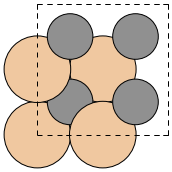

In [41]:
# Interakcja
@interact(x=(0.0,180),y=(0.0,180),c=fixed(SiC))
def show_cryst(x,y,c):
    f=BytesIO()
    ase.io.write(f, c, show_unit_cell=2, format='png',
                 rotation='%.0fy,%.0fx' % (y,x), scale=30) 
    return Image(data=bytes(f.getbuffer()),format='png')

### Wyświetlanie wyższej jakości

Biblioteka ASE pozwala na użycie zewnętrznego programu w celu uzyskania bardziej
widowiskowego obrazu struktury.

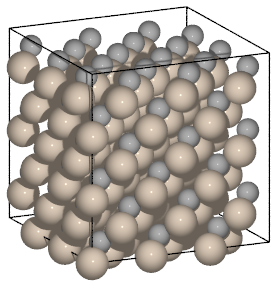

In [58]:
# Narysujmy większy fragment struktury
# Tym razem wyświetlony z użyciem zewnętrznego programu povray
bSiC=SiC.repeat(3)
ase.io.write('bSiC.pov', bSiC, show_unit_cell=2, rotation='115y,15x', run_povray=True)
Image(filename='bSiC.png')

### Bardziej złożone struktury

Biblioteka ASE udostępnia także funkcje wspomagające konstrukcję bardziej złożonych struktur: nanotaśm, nanorurek, powierzchni i wielu innych. Można także łatwo tworzyć struktury przy pomocy własnych procedur.

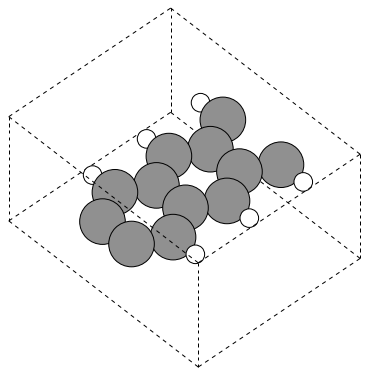

In [57]:
# Nanotaśma grafitowa
gnr = graphene_nanoribbon(2, 3, type='zigzag', saturated=True)

interact(show_cryst,x=(0.0,180),y=(0.0,180),c=fixed(gnr));

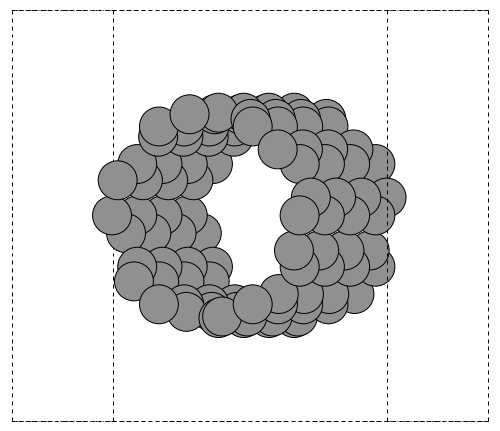

In [67]:
# Nanorurka
cnt = nanotube(6, 6, length=4, bond=1.4)
#show_cryst(15,115,cnt)
interact(show_cryst,x=(0.0,180),y=(0.0,180),c=fixed(cnt));

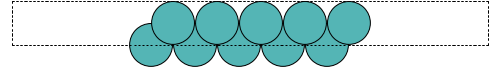

In [87]:
# Powierzchnia (1,0,0) molibdenu
Mo = bulk('Mo', 'bcc', a=3.16, cubic=True)
s = surface(Mo, (1, 0, 0),5, vacuum=10)
interact(show_cryst,x=(0.0,180),y=(0.0,180),c=fixed(s));

In [88]:
from ase import Atoms
from ase.units import Ry
from ase.calculators.abinit import Abinit

a0 = 5.43
bulk = Atoms('Si2', [(0, 0, 0),
                     (0.25, 0.25, 0.25)],
             pbc=True)
b = a0 / 2
bulk.set_cell([(0, b, b),
               (b, 0, b),
               (b, b, 0)], scale_atoms=True)

calc = Abinit(label='Si',
              nbands=8,  # one can specify any abinit keywords
              ecut=10 * Ry,  # warning - used to speedup the test
              kpts=[4, 4, 4],  # warning - used to speedup the test
              chksymbreak=0,
              )

# one can specify abinit keywords also using set
calc.set(toldfe=1.0e-2)  # warning - used to speedup the test
bulk.set_calculator(calc)
e = bulk.get_potential_energy()

RuntimeError: No pseudopotential for Si!